 Example.jl













 Paul.Soderlind@unisg.ch   May 2013, to Julia Jan 2016

In [1]:
using Optim, SpecialFunctions, Statistics
include("HistogramFitfn.jl")         #functions used


CaseQ = 3               #try 1,2, or 3 (see Prob below)

3

In [2]:
                                                #DATA
#catogories, -Inf<x<=Bound(1),Bond(1)<x<=Bound(2),..,Bound(n)<x<=Inf
CatBounds = [-2.00;-1.00; 0.00; 1.00; 2.00; 3.00; 4.00; 5.00; 6.00]
#mid points, first and last interval are artificially closed
CatMid    = [-2.50;-1.50;-0.50; 0.50; 1.50; 2.50; 3.50; 4.50; 5.50; 6.50]

if CaseQ == 1          #only one interval has non-zero prob
  Prob = [ 0.00; 0.00; 0.00; 0.00; 1.00; 0.00; 0.00; 0.00; 0.00; 0.00]
elseif CaseQ == 2      #two intervals have non-zero prob
  Prob = [ 0.00; 0.00; 0.00; 0.00; 0.30; 0.70; 0.00; 0.00; 0.00; 0.00]
elseif CaseQ == 3      #3 or more intervals have non-zero prob
  Prob = [ 0.00; 0.00; 0.00; 0.10; 0.30; 0.40; 0.15; 0.05; 0.00; 0.00]   #probabilities
end

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.1
 0.3
 0.4
 0.15
 0.05
 0.0
 0.0

In [3]:
if sum(Prob) != 1
  error("probabilities do not sum to one")
end

MeanCrude = sum(Prob .* CatMid)                    #crude mean and variance
VarCrude  = sum(Prob .* (CatMid.-MeanCrude).^2)

BinWidth    = mean(diff(CatBounds))
VarSheppard = VarCrude - BinWidth^2/12       #variance, Sheppard's correction

0.9041666666666667

In [4]:
NActiveCat = sum(Prob .> 0)      #no. intervals with non-zero probabilities

if NActiveCat == 1        #if only one active intervals: triangular distribution
   parM = Any[MeanCrude;sqrt(BinWidth^2/24);NActiveCat]
elseif NActiveCat == 2        #if only two active intervals: N(MeanCrude,VarSheppard)
   parM = Any[MeanCrude;sqrt(VarSheppard);NActiveCat]
elseif NActiveCat > 2         #if three or more active intervals: N(estimate,estimate)
  par0 = [MeanCrude;sqrt(VarSheppard)]
  Sol  = optimize(par->NormalHistLoss(par,Prob,CatBounds),par0)
  par1 = Optim.minimizer(Sol)
  parM = Any[par1;NActiveCat]
end
println("\n[mean,std]=$(round.(parM[1:2]',digits=3)), no. active intervals: $(parM[3])")


[mean,std]=[2.205 0.935], no. active intervals: 5


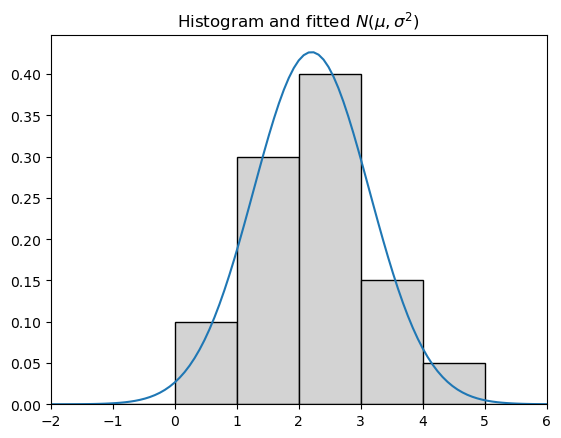

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001544DA6D3F0>

In [5]:
#Comment out this if you do not have PyPlot installed.

using PyPlot
PyPlot.svg(false)           #prettier if `true`
close("all")

if NActiveCat == 1                           #assumed triangular dist
  whichBin = findfirst(Prob .== 1)
  (a,b,c) = (CatBounds[whichBin-1],CatBounds[whichBin],CatMid[whichBin]) #for distribution
  y    = range(a,stop=b,length=101)
  pdfy = TriangularPdfPs.(y,a,b,c)
  figure()
    bar(CatMid,Prob/BinWidth,width=BinWidth,color="lightgray",edgecolor="black",align="center")
    xlim(-2,6)
    title("Histogram and assumed triangular distribution")
    plot(y,pdfy)
    #display(gcf())          #uncomment in VsCode
elseif NActiveCat >= 2                           #fitted N(mu,s^2)
  y    = range(-2,stop=6,length=101)
  pdfy = NormPdfPs.(y,parM[1],parM[2]^2)
  figure()
    bar(CatMid,Prob/BinWidth,width=BinWidth,color="lightgray",edgecolor="black",align="center")
    xlim(-2,6)
    title("Histogram and fitted \$N(\\mu,\\sigma^2)\$")
    plot(y,pdfy)
    #display(gcf())          #uncomment in VsCode
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*